In [ ]:
!unzip -q vk-made-ocr.zip

In [4]:
!ls

cleaned_data.csv  sample_data		 test		train_labels.csv
crnn.pth	  sample_submission.csv  test_data.csv	vk-made-ocr.zip
ocr23.zip	  tb_logs		 train


In [5]:
!ls train/train | wc -l
!ls test/test | wc -l

276000
52999


In [6]:
import time
from pathlib import Path
from collections import defaultdict

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
#from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.models as models
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
np.random.seed(0)
torch.manual_seed(0);

# Data Exploration

In [8]:
labels_df = pd.read_csv('train_labels.csv')
print(labels_df.shape[0])
labels_df.columns = ['img', 'text']  # Id,	Expected -> img, text
labels_df.head()

276000


img       text
0  1.jpg     Атырау
1  2.jpg      транз
2  3.jpg      ходят
3  4.jpg  ощущений,
4  5.jpg         74

In [9]:
# drop bad labels
print(labels_df['text'].isna().sum())
labels_df.dropna(inplace=True)
labels_df.reset_index(drop=True, inplace=True)

27


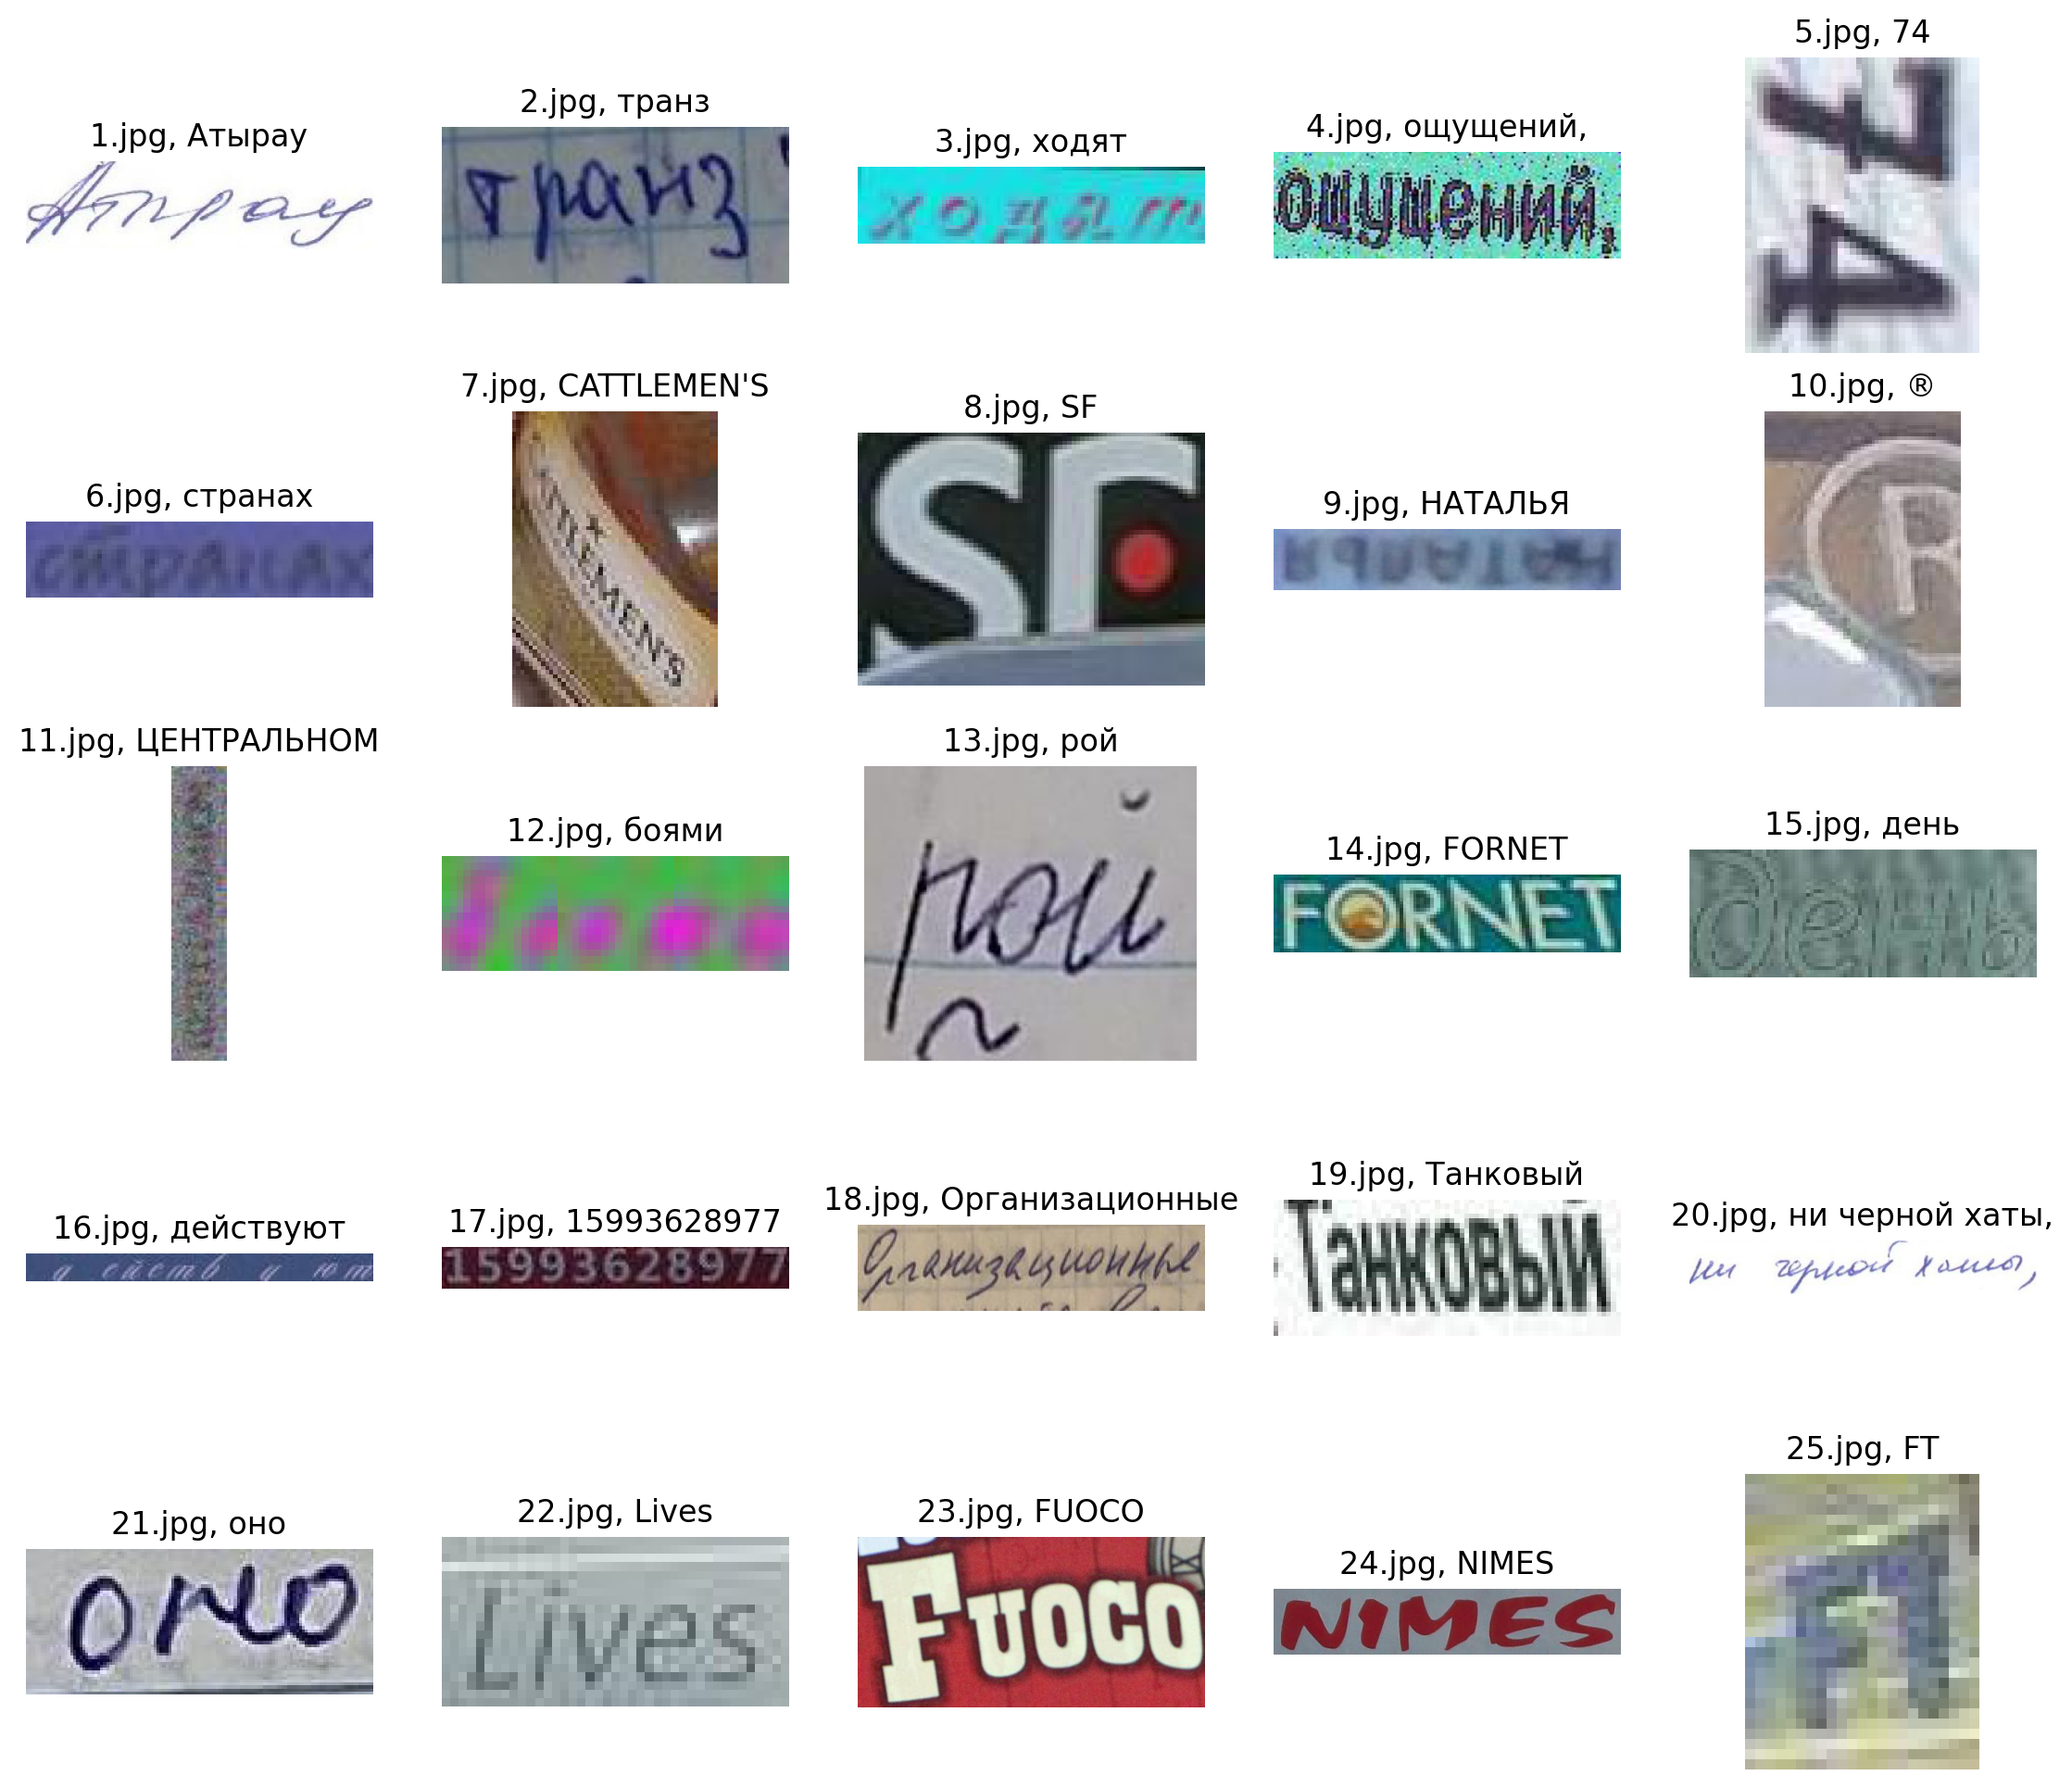

In [10]:
# show first 25 images
plt.figure(figsize=(14, 12))

labeled_data_path = Path('train/train')
for i, (id, lbl) in enumerate(labels_df[0:25].to_numpy()):
    img = plt.imread(labeled_data_path / id)
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.grid(False)
    plt.title(f'{id}, {lbl}')
    plt.axis('off')
    
plt.show()

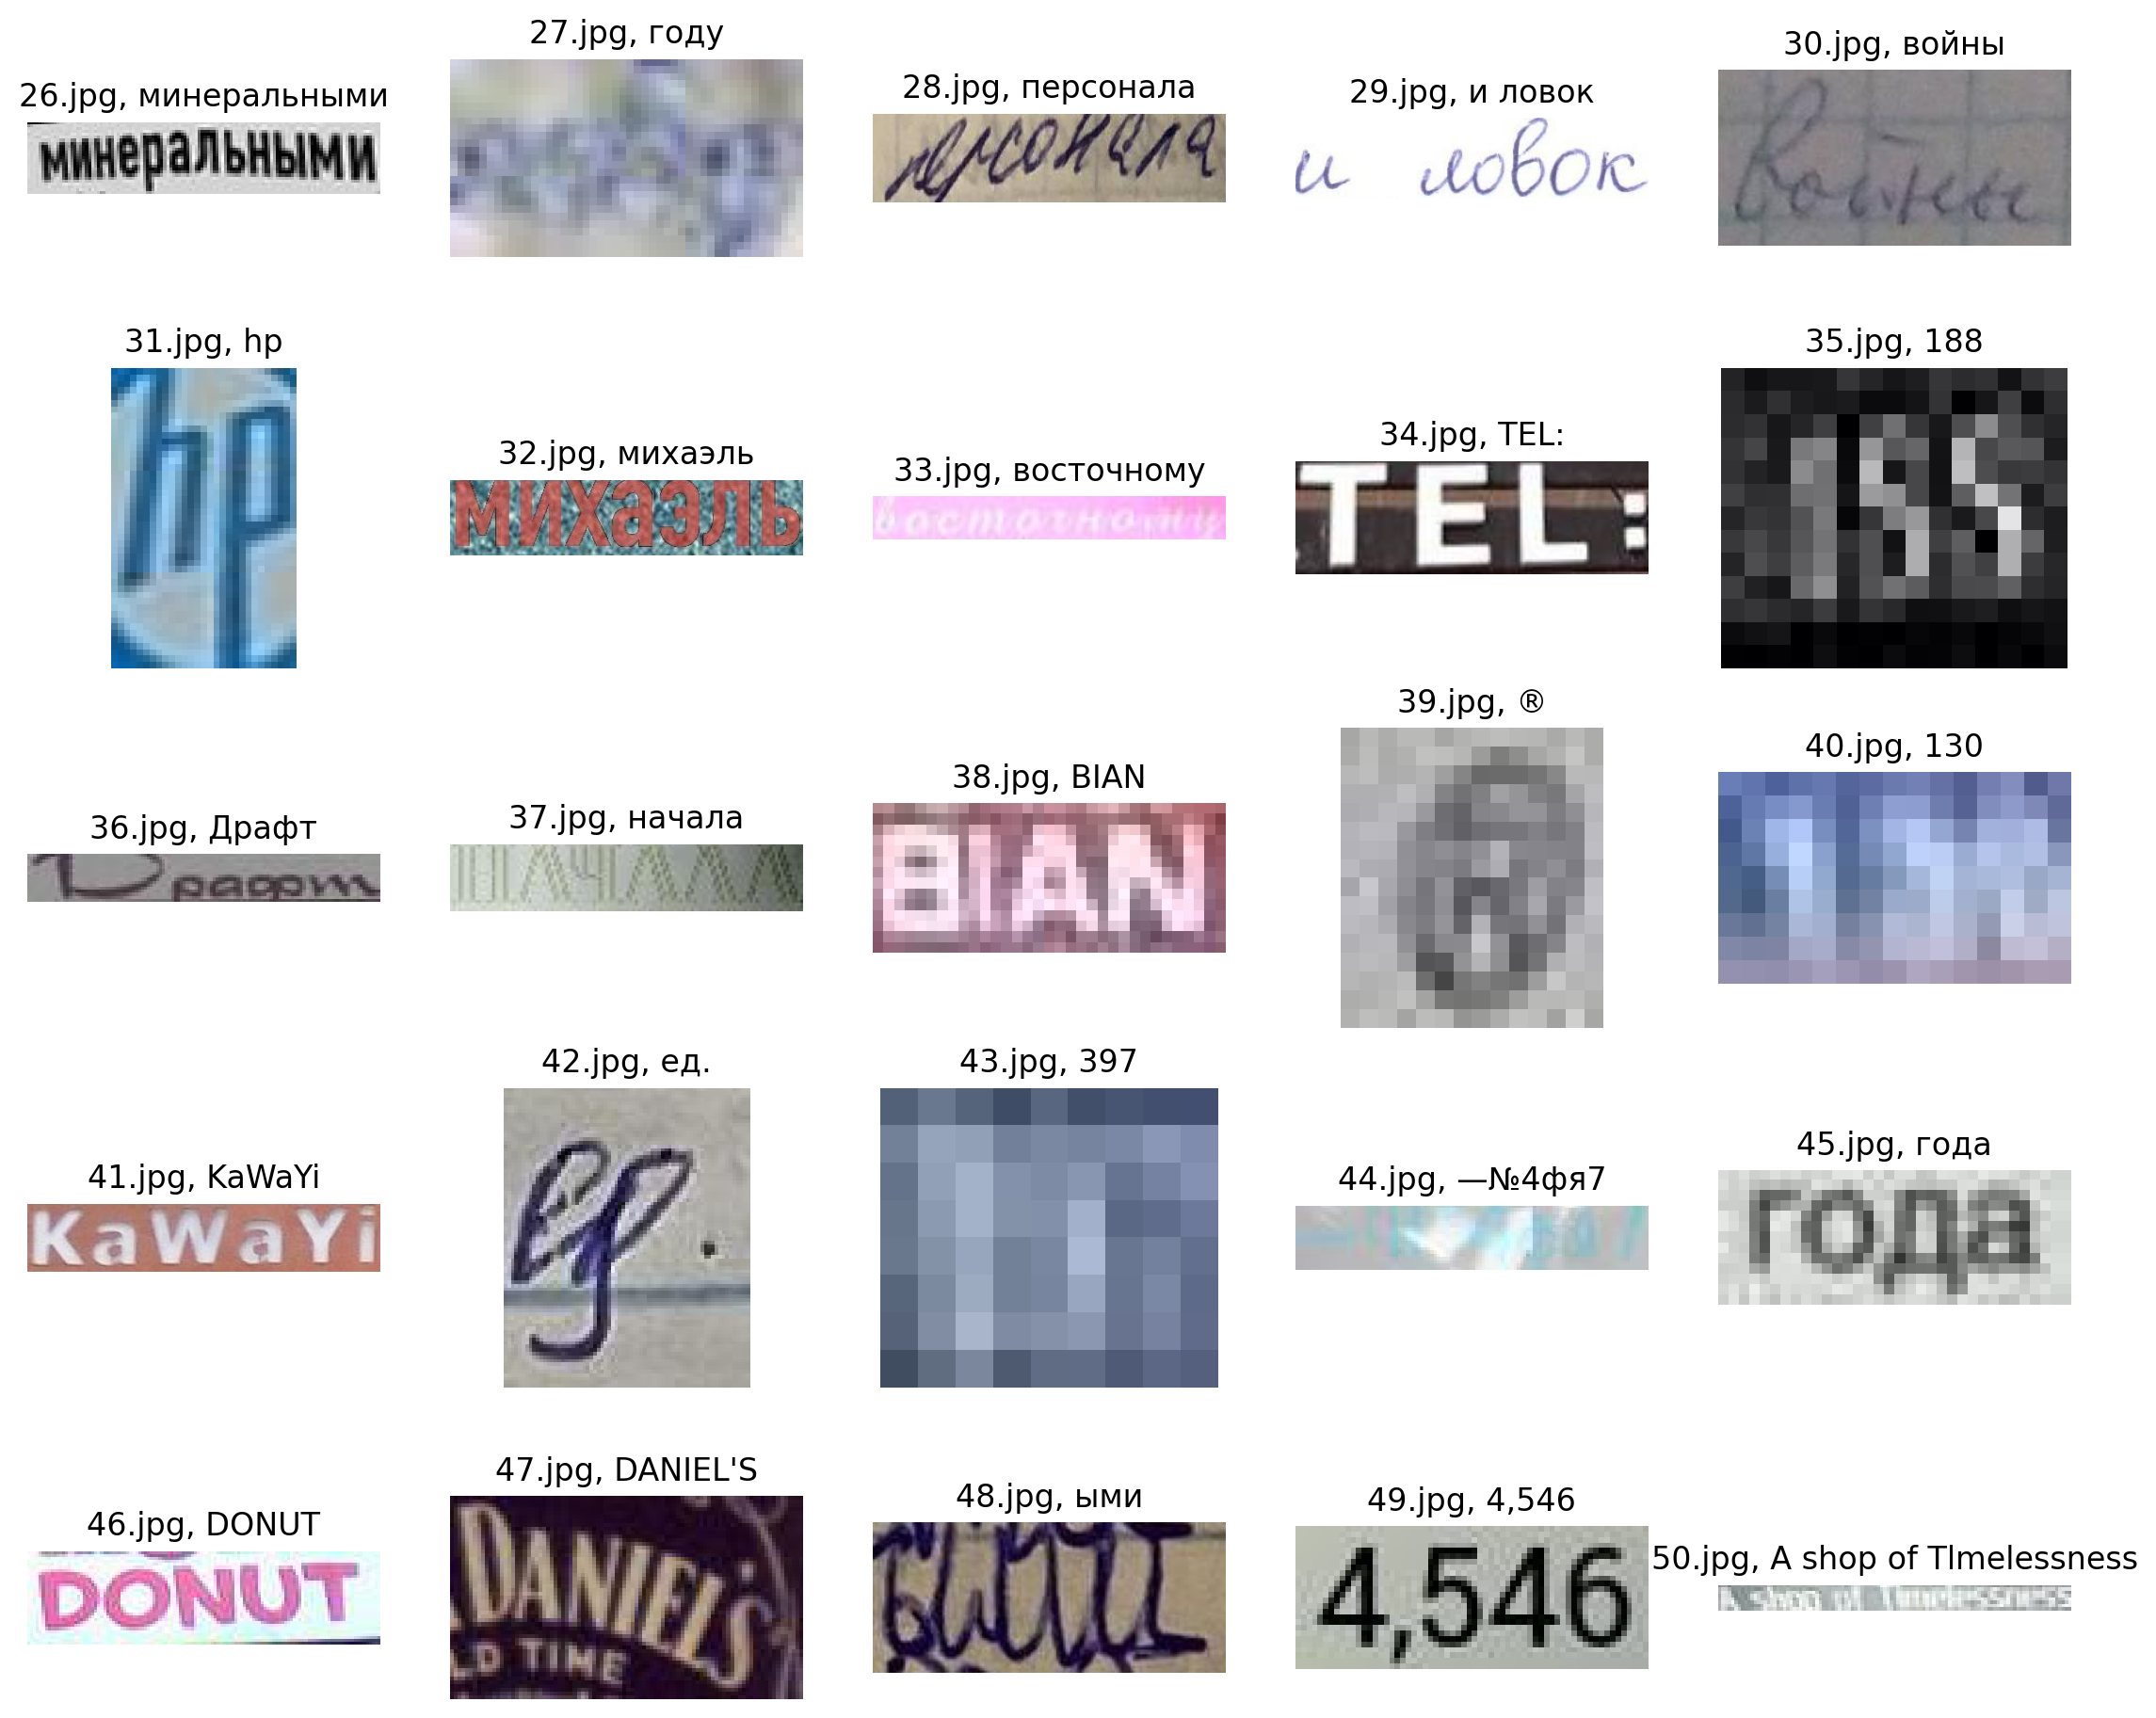

In [11]:
# show second 25 images
plt.figure(figsize=(14, 12))

labeled_data_path = Path('train/train')
for i, (id, lbl) in enumerate(labels_df[25:50].to_numpy()):
    img = plt.imread(labeled_data_path / id)
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.grid(False)
    plt.title(f'{id}, {lbl}')
    plt.axis('off')
    
plt.show()

In [12]:
%%time
labeled_files = [labeled_data_path / id for id in labels_df['img']]
labels_df['img_size'] = [plt.imread(p).shape for p in labeled_files]  # height, width, channels
labels_df['img_ratio'] = labels_df.img_size.apply(lambda x: x[1] / x[0])  # width / height
labels_df['img_mode'] = labels_df.img_size.apply(len)  # mode

CPU times: user 3min 10s, sys: 10.4 s, total: 3min 20s
Wall time: 3min 38s


In [13]:
labels_df.head(5)

img       text      img_size  img_ratio  img_mode
0  1.jpg     Атырау  (77, 303, 3)   3.935065         3
1  2.jpg      транз  (58, 128, 3)   2.206897         3
2  3.jpg      ходят   (21, 95, 3)   4.523810         3
3  4.jpg  ощущений,  (45, 146, 3)   3.244444         3
4  5.jpg         74   (48, 38, 3)   0.791667         3

Image size analysis

In [14]:
print('width:\n', labels_df.img_size.apply(lambda x: x[1]).describe(), '\n')  # widths
print('height:\n', labels_df.img_size.apply(lambda x: x[0]).describe(), '\n')  # heights
print(labels_df.img_mode.value_counts())  # mode

width:
 count    275973.000000
mean        189.959373
std         194.488770
min           2.000000
25%          60.000000
50%         126.000000
75%         256.000000
max        4012.000000
Name: img_size, dtype: float64 

height:
 count    275973.000000
mean         55.705464
std          61.086744
min           1.000000
25%          19.000000
50%          38.000000
75%          73.000000
max        1827.000000
Name: img_size, dtype: float64 

3    275973
Name: img_mode, dtype: int64


count    275973.000000
mean          3.996655
std           2.958163
min           0.038462
25%           2.000000
50%           3.428571
75%           5.291667
max         373.000000
Name: img_ratio, dtype: float64


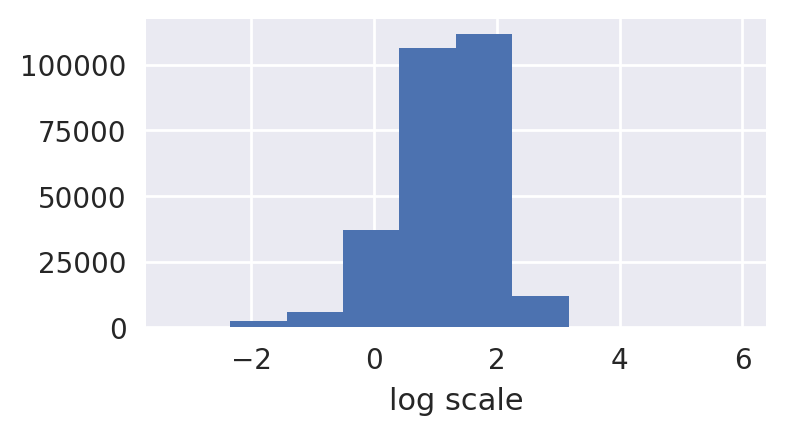

In [15]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(4, 2))
    plt.xlabel('log scale')
    np.log(labels_df.img_ratio).hist()

print(labels_df.img_ratio.describe())

In [38]:
# small images
IMG_SIZE_THRESH = 5
small_imgs_df = labels_df[(labels_df.img_size.apply(lambda x: x[1]) <= IMG_SIZE_THRESH) | 
                          (labels_df.img_size.apply(lambda x: x[0]) <= IMG_SIZE_THRESH)]
print(small_imgs_df.shape[0])
small_imgs_df.head()

244


img  text    img_size  img_ratio  img_mode
2702  2703.jpg     0   (4, 9, 3)   2.250000         3
2817  2818.jpg     R   (5, 6, 3)   1.200000         3
3751  3752.jpg   TCL  (5, 14, 3)   2.800000         3
4597  4598.jpg  2010  (5, 26, 3)   5.200000         3
5496  5497.jpg     5   (7, 5, 3)   0.714286         3

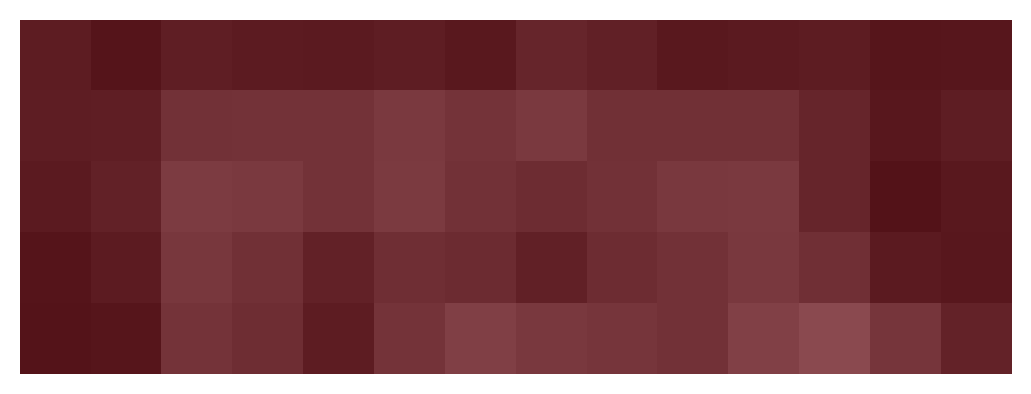

In [46]:
img = plt.imread(labeled_data_path / '3752.jpg')
plt.imshow(img), plt.grid(False), plt.axis('off');

In [52]:
# deleting small images
labels_df = labels_df[~labels_df.index.isin(small_imgs_df.index)]
labels_df.reset_index(drop=True, inplace=True)
print(labels_df.shape[0])

275729


In [53]:
labels_df[labels_df.img_ratio < 1]  # vertical text orientation or short label length

img         text      img_size  img_ratio  img_mode
4            5.jpg           74   (48, 38, 3)   0.791667         3
6            7.jpg  CATTLEMEN'S   (72, 50, 3)   0.694444         3
9           10.jpg            ®   (83, 55, 3)   0.662651         3
10          11.jpg  ЦЕНТРАЛЬНОМ  (108, 20, 3)   0.185185         3
24          25.jpg           FT   (29, 23, 3)   0.793103         3
...            ...          ...           ...        ...       ...
275673  275945.jpg            2   (19, 16, 3)   0.842105         3
275692  275964.jpg           AJ   (24, 23, 3)   0.958333         3
275696  275968.jpg            I   (50, 19, 3)   0.380000         3
275716  275988.jpg            ?   (87, 52, 3)   0.597701         3
275725  275997.jpg       BASUCC   (26, 11, 3)   0.423077         3

[20998 rows x 5 columns]

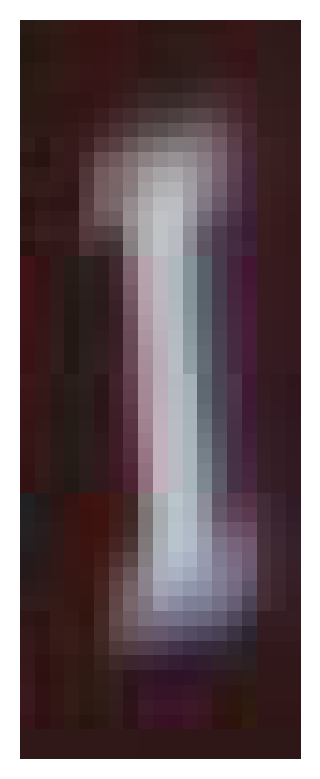

In [54]:
img = plt.imread(labeled_data_path / '275968.jpg')
plt.imshow(img), plt.grid(False), plt.axis('off');

Symbols count analysis

In [55]:
symbols = defaultdict(int)
for lbl in labels_df['text']:
    for c in lbl:
        symbols[c] += 1
print(len(symbols))

608


[('о', 109470), ('а', 98383), ('е', 87551), ('и', 78191), ('н', 73121), ('т', 64832), ('с', 61069), ('р', 58994), ('л', 48676), ('к', 42546), ('в', 42451), ('м', 33725), ('д', 31624), ('1', 31574), (' ', 30726), ('0', 30257), ('п', 27251), ('у', 26746), ('я', 25201), ('.', 23446), ('ы', 21627), ('2', 21099), ('A', 20841), (',', 20221), ('E', 19821), ('г', 18660), ('з', 17925), ('ь', 17852), ('3', 17509), ('б', 17067), ('8', 16966), ('5', 16633), ('e', 16583), ('I', 16542), ('O', 15876), ('й', 15552), ('N', 15212), ('9', 15203), ('6', 14503), ('А', 14413), ('7', 14250), ('a', 14216), ('О', 13940), ('ч', 13911), ('S', 13791), ('T', 13676), ('4', 13154), ('i', 13109), ('R', 12922), ('-', 12495), ('o', 12168), ('n', 11616), ('К', 11342), ('С', 11291), ('C', 10880), ('L', 10799), ('х', 10508), ('И', 10014), ('ж', 9881), ('r', 9356), ('t', 9314), ('Н', 9304), ('Р', 8875), ('Е', 8787), ('Т', 8368), ('H', 7765), ('ш', 7674), ('В', 7656), ('s', 7207), ('ю', 7184), ('П', 7183), ('U', 7144), ('M'

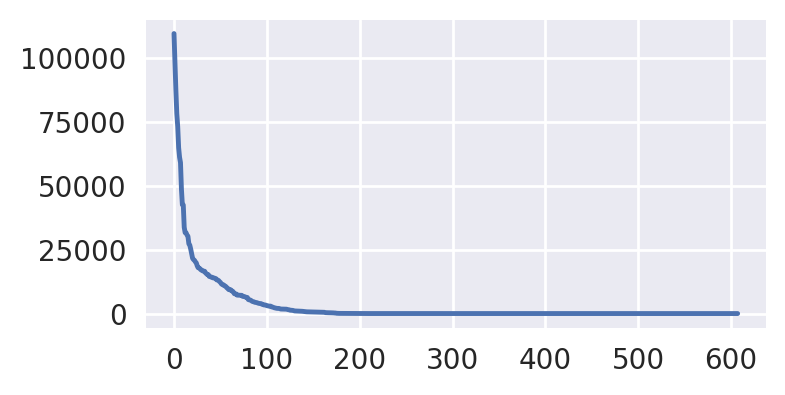

In [56]:
sorted_symb = sorted(symbols.items(), key=lambda kv: kv[1], reverse=True)
print(sorted_symb[:100])

with plt.style.context('seaborn'):
    plt.figure(figsize=(4, 2))
    plt.plot([v for k, v in sorted_symb]);

Finding rare symbols

251
357


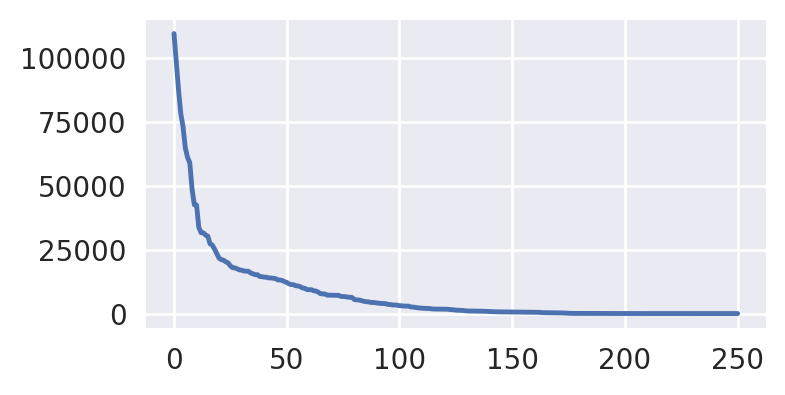

In [57]:
SYMB_COUNT_THRESH = 3
cropped_symb = [(char, freq) for char, freq in sorted_symb if freq > SYMB_COUNT_THRESH]
deleted_symb = [char for char, freq in sorted_symb if freq <= SYMB_COUNT_THRESH]
print(len(cropped_symb))
print(len(deleted_symb))

with plt.style.context('seaborn'):
    plt.figure(figsize=(4, 2))
    plt.plot([v for k, v in cropped_symb]);

In [58]:
labels_df[labels_df['text'].str.contains('|'.join(deleted_symb))]  # | if a string contains one of the substrings in a list

img                                  text      img_size  \
2262      2263.jpg                                   山形県   (18, 32, 3)   
3997      4001.jpg                                    法意   (18, 52, 3)   
4087      4091.jpg                              (最好的時刻).  (22, 190, 3)   
5139      5144.jpg                         Yan ′  s Acup  (43, 219, 3)   
7586      7593.jpg                                   追分駅  (29, 128, 3)   
...            ...                                   ...           ...   
268264  268534.jpg               Public  Ｗashroom　ＷＣ　060  (38, 324, 3)   
268856  269126.jpg                                   (賈)   (28, 44, 3)   
271651  271922.jpg                              9183329¤  (21, 110, 3)   
273884  274156.jpg  IA ΦΘH bAPИΛbIH MATEPИAΛbIH XyIAΛIAA  (51, 529, 3)   
274725  274997.jpg                              ２０ｉ-ＶＴＥＣ   (11, 81, 3)   

        img_ratio  img_mode  
2262     1.777778         3  
3997     2.888889         3  
4087     8.636364         3  
5139     5.093023         3  
7586     4.413793         3  
...           ...       ...  
268264   8.526316         3  
268856   1.571429         3  
271651   5.238095         3  
273884  10.372549         3  
274725   7.363636         3  

[220 rows x 5 columns]

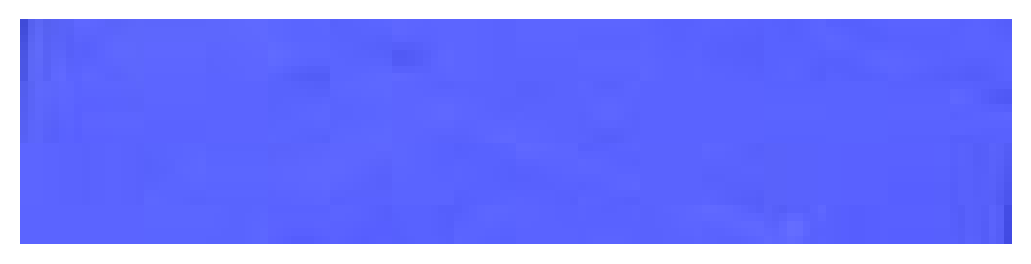

In [59]:
img = plt.imread(labeled_data_path / '7593.jpg')
plt.imshow(img), plt.grid(False), plt.axis('off');

In [60]:
# deleting samples with rare characters
labels_df = labels_df[~labels_df['text'].str.contains('|'.join(deleted_symb))]
labels_df.reset_index(drop=True, inplace=True)
print(labels_df.shape[0])

275509


In [68]:
alphabet = ''.join([ch for ch, _ in cropped_symb])
alphabet

'оаеинтсрлквмд1 0пуя.ы2A,Eгзь3б85eIOйN96А7aОчST4iR-onКСCLхИжrtНРЕТHшВsюПUMlGPDМцЛДcBuУ"hFГdщmБYф)gЯЗK:(VWpёэЧyЖЙbЫfШwXЬZkФJХЮv!;?ЭЦz»%/«\'ъ®&’+Щ*$][|#Q№—–@_Ёx{=`>Ъ<}：＃j“‐„і”І·~q…￥€！，°（）¥お、＆Қ©\\।é×→←Ⓡ£қ\xadΛ駅өα｜大\u200cοä•−‘ü－▪。わÉ℃●ς₩★─ν傳سōσρàÖў\u3000∧λ０τ™เ├الπεї＇Αりう²１'

In [61]:
labels_df.to_csv('cleaned_data.csv', header=True, index=False)

Test data image size analysis

In [29]:
%%time
test_data_path = Path('test/test')
test_files = list(test_data_path.glob('*'))
test_df = pd.DataFrame()
test_df['img'] = [p.name for p in test_files]
test_df['img_size'] = [plt.imread(p).shape for p in test_files]
test_df['img_ratio'] = test_df.img_size.apply(lambda x: x[1] / x[0])  # width / height
test_df['img_mode'] = test_df.img_size.apply(len)

CPU times: user 37 s, sys: 3.42 s, total: 40.4 s
Wall time: 54.2 s


In [30]:
print('width:\n', test_df.img_size.apply(lambda x: x[1]).describe(), '\n')  # widths
print('height:\n', test_df.img_size.apply(lambda x: x[0]).describe(), '\n')  # heights
print(test_df.img_mode.value_counts())  # mode

width:
 count    52999.000000
mean       145.856488
std        181.659128
min          2.000000
25%         37.000000
50%         75.000000
75%        176.000000
max       3131.000000
Name: img_size, dtype: float64 

height:
 count    52999.000000
mean        59.920338
std         86.908728
min          4.000000
25%         18.000000
50%         32.000000
75%         71.000000
max       1767.000000
Name: img_size, dtype: float64 

3    52999
Name: img_mode, dtype: int64


count    52999.000000
mean         3.273910
std          2.684590
min          0.036554
25%          1.466667
50%          2.636364
75%          4.437500
max         45.875000
Name: img_ratio, dtype: float64


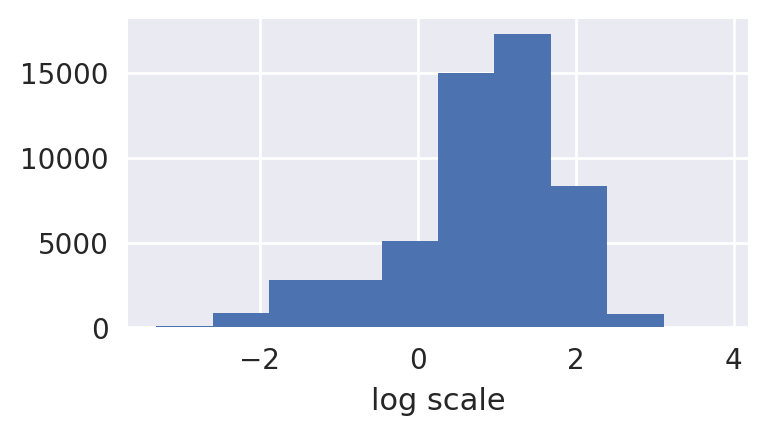

In [31]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(4, 2))
    plt.xlabel('log scale')
    np.log(test_df.img_ratio).hist()

print(test_df.img_ratio.describe())

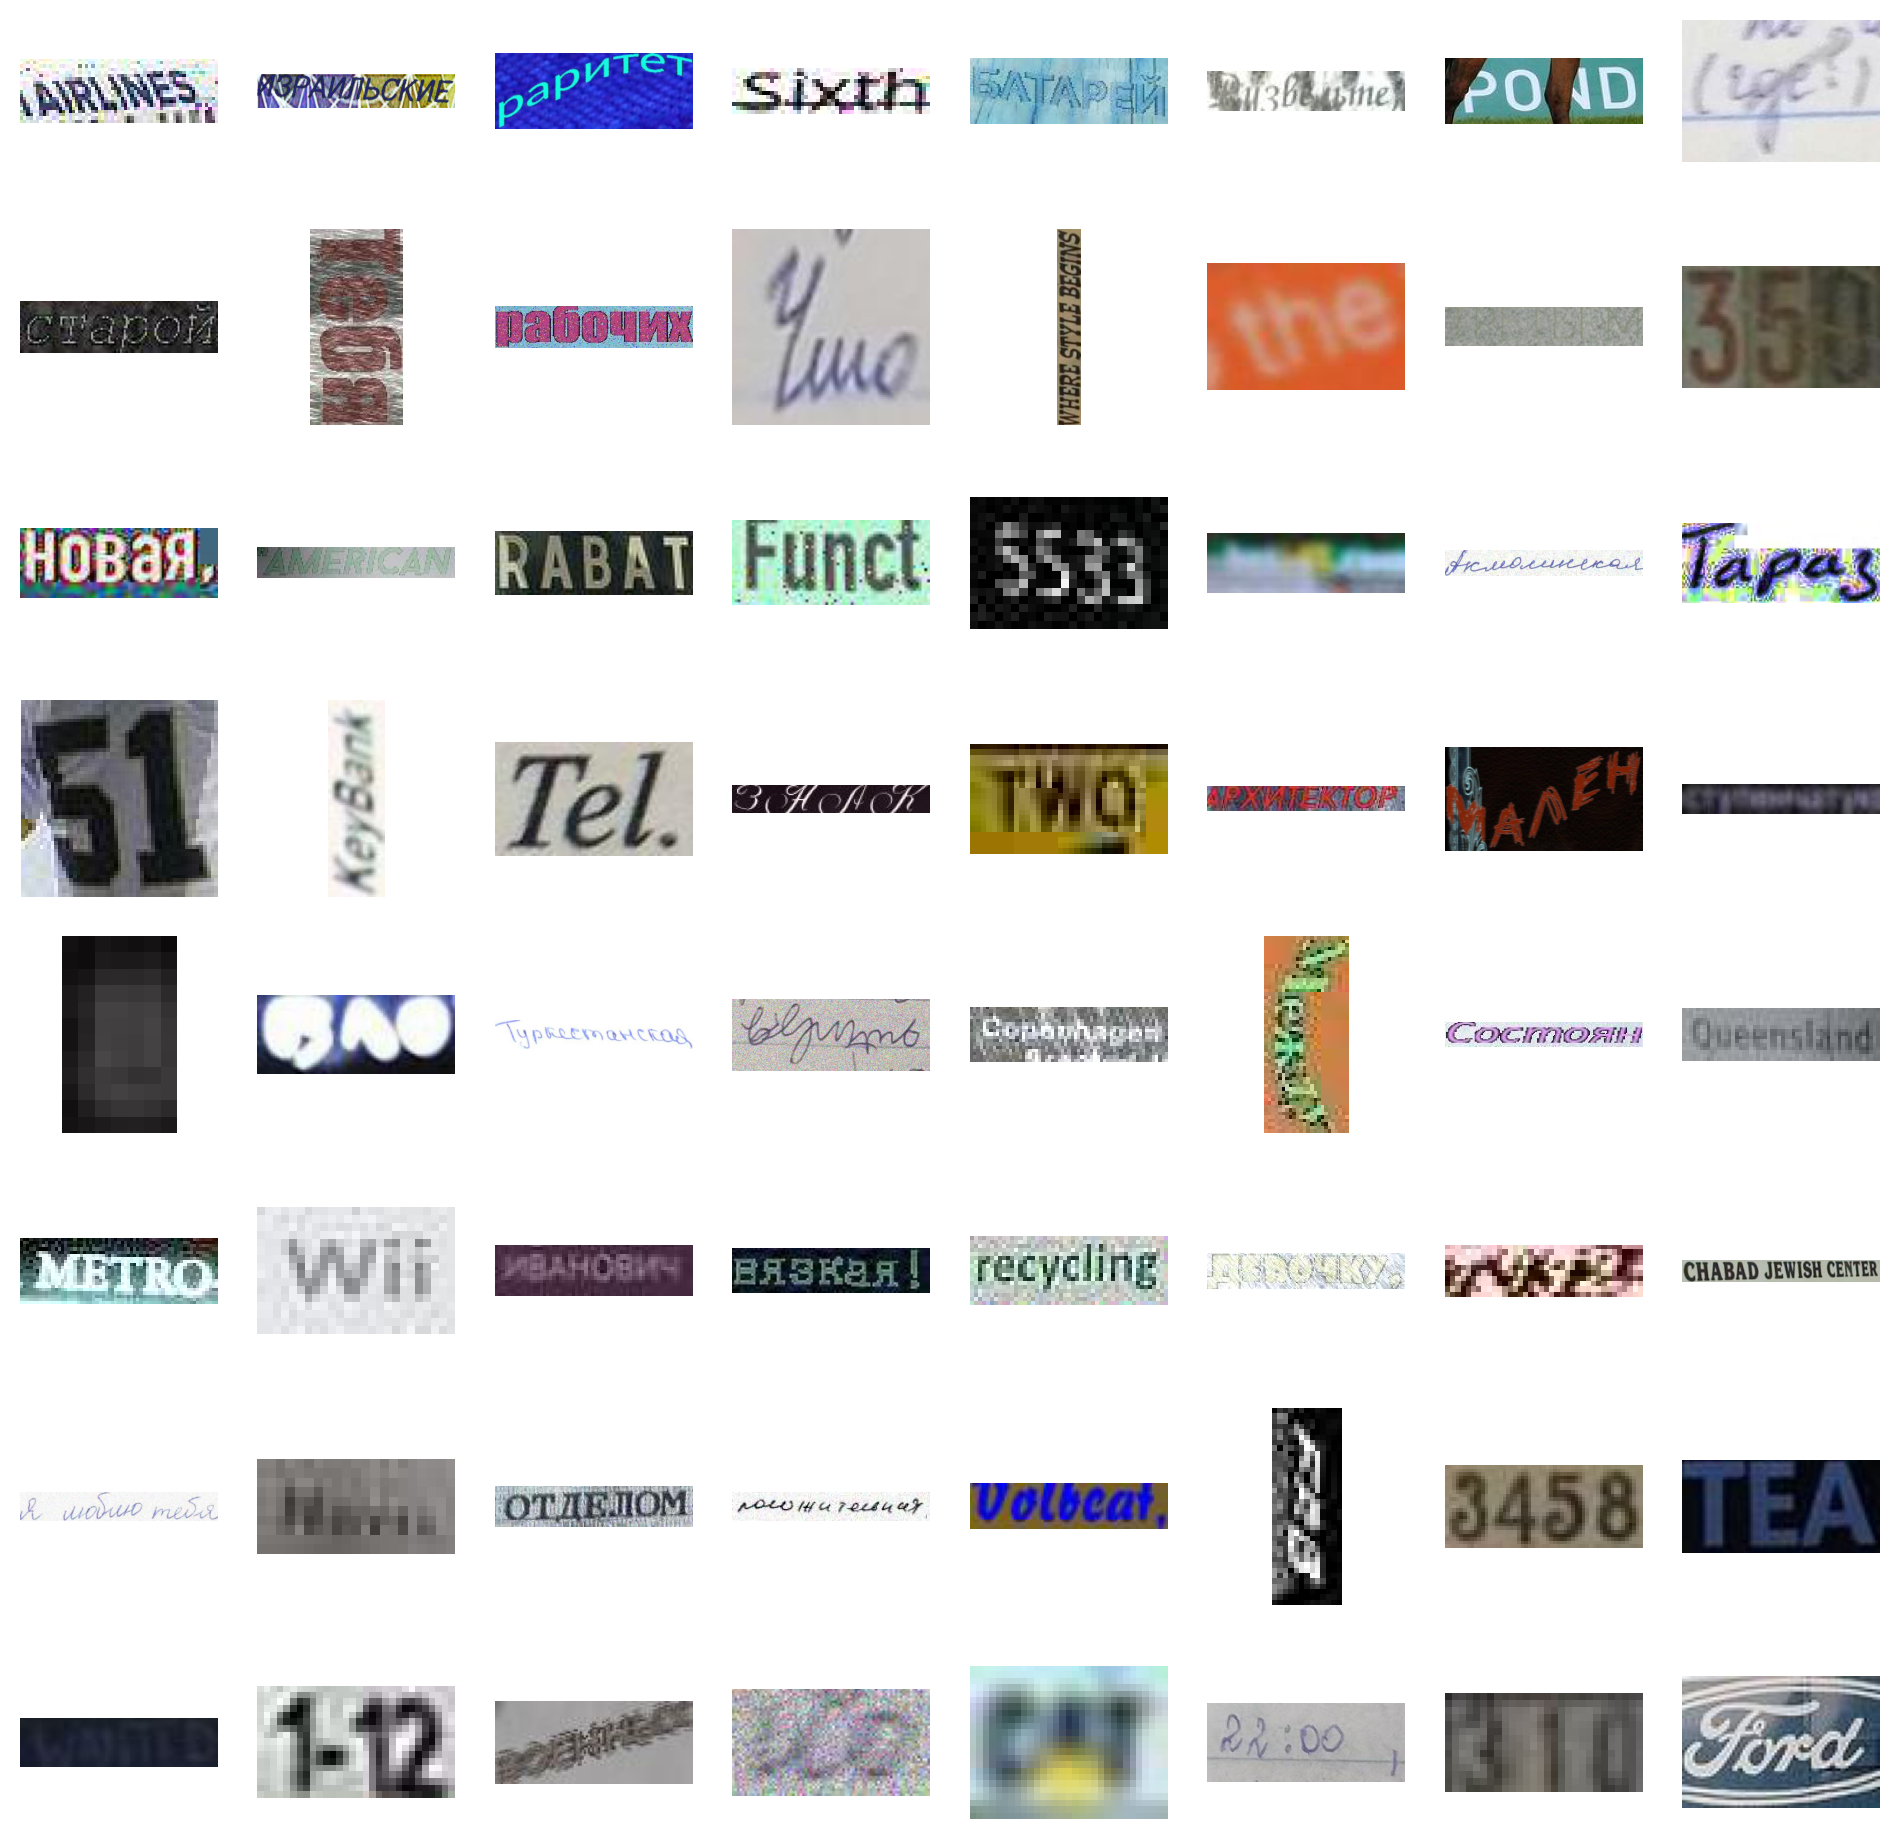

In [32]:
# show first 64 images
plt.figure(figsize=(12, 12))

for i, f in enumerate(test_files[0:64]):
    img = plt.imread(f)
    plt.subplot(8, 8, i + 1)
    plt.imshow(img)
    plt.grid(False)
    plt.axis('off')
    
plt.show()

In [63]:
# small images in test
test_df[(test_df.img_size.apply(lambda x: x[1]) <= IMG_SIZE_THRESH) | 
        (test_df.img_size.apply(lambda x: x[0]) <= IMG_SIZE_THRESH)].shape[0]

36

In [71]:
test_df.to_csv('test_data.csv', header=True, index=False)

# Dataset

In [8]:
class RecognitionDataset(Dataset):
    def __init__(self, files_dir, data_df, alphabet, transforms,
                 split='train', train_size=0.8):
        super().__init__()
        self.files_dir = Path(files_dir)
        self.alphabet = alphabet
        self.alphabet_dict = {c: i + 1 for i, c in enumerate(alphabet)}
        self.transforms = transforms
        self.split = split
        self.train_size = train_size

        if split in ['train', 'val']:
            img_filenames = data_df['img'].values
            train_val_border = int(len(img_filenames) * train_size) + 1
            first, last = (0, train_val_border) if split == 'train' \
                else (train_val_border, len(img_filenames))
            self.filenames = img_filenames[first:last]
            img_labels = data_df['text'].values
            self.labels = img_labels[first:last]
            return
        if split == 'test':
            self.filenames = data_df['img'].values
            return
        raise NotImplementedError(f'Unknown split: {split}')

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image = cv2.imread(str(self.files_dir / filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.split == 'test':
            #output = dict(image=image, filename=filename)
            output = dict(image=image, seq=[], seq_len=0, text=[], filename=filename)
        else:
            text = self.labels[idx]
            seq = self._text_to_seq(text)
            output = dict(image=image, seq=seq, seq_len=len(seq),
                          text=text, filename=filename)
        if self.transforms is not None:
            output['image'] = self.transforms(output['image'])
        return output

    def _text_to_seq(self, text):
        # encode text to sequence of integers
        # Returns list of integers where each number is index of corresponding character in alphabet + 1
        # seq = [self.alphabet.find(c) + 1 for c in text]  # 0 -> blank
        seq = [self.alphabet_dict[c] for c in text]  # 0 -> blank
        return seq

    def __len__(self):
        return len(self.filenames)

In [9]:
alphabet = """оаеинтсрлквмд1 0пуя.ы2A,Eгзь3б85eIOйN96А7aОчST4iR-onКСCLхИжrtНРЕТHшВsюПUMlGPDМцЛДcBuУ"hFГdщmБYф)gЯЗK:(VWpёэЧyЖЙbЫfШwXЬZkФJХЮv!;?ЭЦz»%/«'ъ®&’+Щ*$][|#Q№—–@_Ёx{=`>Ъ<}：＃j“‐„і”І·~q…￥€！，°（）¥お、＆Қ©\।é×→←Ⓡ£қ­Λ駅өα｜大‌οä•−‘ü－▪。わÉ℃●ς₩★─ν傳سōσρàÖў　∧λ０τ™เ├الπεї＇Αりう²１"""
alphabet_dict = {ch: i + 1 for i, ch in enumerate(alphabet)}
[alphabet_dict[c] for c in 'abcd']

[42, 112, 82, 90]

In [10]:
class Cv2RezizeAndRotateTrain():
    def __init__(self, output_size=(320, 64)):
        self.output_size = output_size

    def __call__(self, img, seq_len):
        w, h = img.shape[1], img.shape[0]
        if h > w and seq_len > 2:  # w / h < 0.2 
            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
            # https://github.com/argman/EAST/issues/368
        if w > self.output_size[0]:
            # https://docs.opencv.org/3.4/da/d6e/tutorial_py_geometric_transformations.html
            # Preferable interpolation methods are cv.INTER_AREA for shrinking 
            # and cv.INTER_CUBIC (slow) & cv.INTER_LINEAR for zooming.
            img = cv2.resize(img, self.output_size, interpolation=cv2.INTER_AREA)
        else:
            img = cv2.resize(img, self.output_size, interpolation=cv2.INTER_CUBIC)
        return img.astype(np.uint8)


class Cv2Rezize():
    def __init__(self, output_size=(320, 64)):
        self.output_size = output_size

    def __call__(self, img):
        h, w = img.shape[:2]
        if w > self.output_size[0]:
            img = cv2.resize(img, self.output_size, interpolation=cv2.INTER_AREA)
        else:
            img = cv2.resize(img, self.output_size, interpolation=cv2.INTER_CUBIC)
        return img.astype(np.uint8)

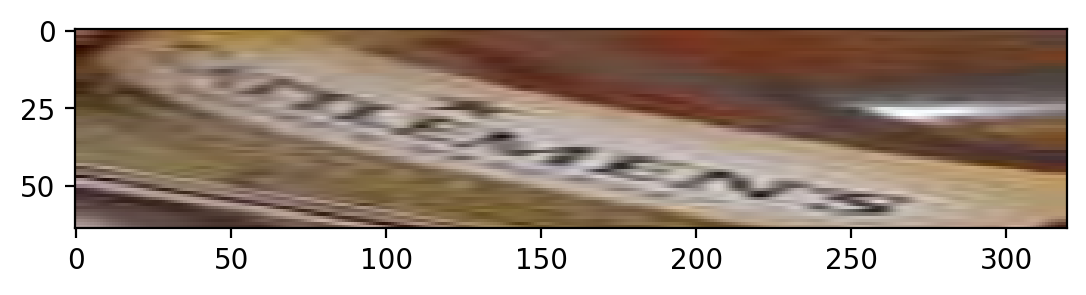

In [11]:
img = cv2.imread('train/train/7.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Cv2Rezize()(img)
plt.imshow(img);

(45, 146, 3)
(45, 50, 3)


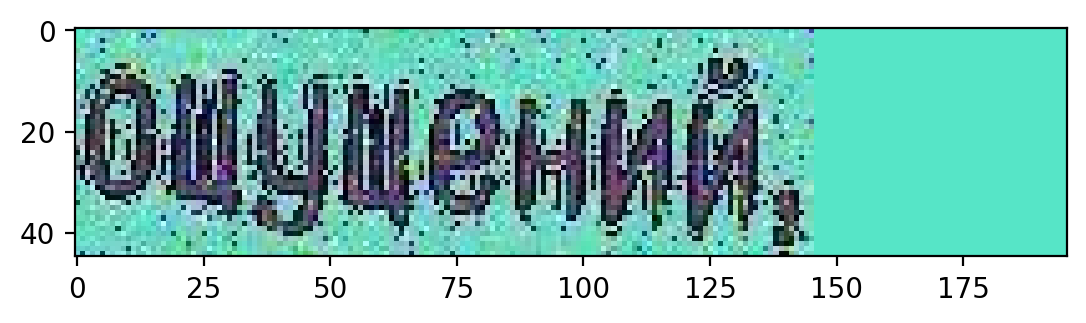

In [20]:
img = cv2.imread('train/train/4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]
print(img.shape)
add_pixels = np.ones((h, 50, 3), dtype=np.uint8) * img[0, 0, :]
print(add_pixels.shape)
img = np.concatenate((img, add_pixels), axis=1)
plt.imshow(img);

# CRNN

In [12]:
class FeatureExtractor(nn.Module):
    def __init__(self, input_size=(64, 320), output_len=50):  # (128, 640)
        # output_len is the size of time steps for the bi-lstm layer
        # https://theailearner.com/2019/05/29/creating-a-crnn-model-to-recognize-text-in-an-image-part-1/
        super().__init__()
        h, w = input_size
        
        # cnn = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        cnn = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights,.IMAGENET1K_V1)

        self.cnn = nn.Sequential(*list(cnn.children())[:-2])
        self.pool = nn.AvgPool2d(kernel_size=(h // 32, 1))
        self.proj = nn.Conv2d(w // 32, output_len, kernel_size=1)  # 320 // 32
        # in_channels, out_channels, kernel_size, stride=1

        # self.num_output_features = self.cnn[-1][-1].bn2.num_features  # resnet18 512
        self.num_output_features = self.cnn[-1][-1][1].num_features  # efficientnet_v2_s 1280

    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Accepts tensor of features (shaped B x C x H x W).
        Returns new tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x

    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        # Pool to make height == 1
        features = self.pool(features)
        # Apply projection to increase width
        features = self.apply_projection(features)
        return features


class SequencePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,
                 dropout=0.3, bidirectional=False):
        super().__init__()
        self.num_classes = num_classes
        self.rnn = nn.GRU(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, dropout=dropout,
            bidirectional=bidirectional
        )
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = nn.Linear(in_features=fc_in, out_features=num_classes)

    def _init_hidden_(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        Accepts batch size.
        Returns tensor of zeros shaped
        (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        return torch.zeros(self.rnn.num_layers * num_directions,
                           batch_size, self.rnn.hidden_size)

    def _prepare_features_(self, x):
        """Change dimensions of x to fit RNN expected input.
        Accepts tensor x shaped (B x (C=1) x H x W).
        Returns new tensor shaped (W x B x H).
        """
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x

    def forward(self, x):
        x = self._prepare_features_(x)
        batch_size = x.size(1)
        h_0 = self._init_hidden_(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        x = self.fc(x)
        return x


class CRNN(nn.Module):
    def __init__(self, alphabet,
                 cnn_input_size=(64, 320), cnn_output_len=50,
                 rnn_hidden_size=128, rnn_num_layers=2,
                 rnn_dropout=0.3, rnn_bidirectional=False):
        super().__init__()
        self.alphabet = alphabet
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size,
            output_len=cnn_output_len
        )
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, num_layers=rnn_num_layers,
            num_classes=len(alphabet)+1,  # alphabet symbols + blank
            dropout=rnn_dropout, bidirectional=rnn_bidirectional
        )

    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

In [ ]:
!unzip -q ocr23.zip  # cleaned_data.csv, test_data.csv

In [ ]:
!ls

In [65]:
labeled_data_path = Path('train/train')
test_data_path = Path('test/test')

labeled_data_df = pd.read_csv('cleaned_data.csv')
test_df = pd.read_csv('test_data.csv')

alphabet = """оаеинтсрлквмд1 0пуя.ы2A,Eгзь3б85eIOйN96А7aОчST4iR-onКСCLхИжrtНРЕТHшВsюПUMlGPDМцЛДcBuУ"hFГdщmБYф)gЯЗK:(VWpёэЧyЖЙbЫfШwXЬZkФJХЮv!;?ЭЦz»%/«'ъ®&’+Щ*$][|#Q№—–@_Ёx{=`>Ъ<}：＃j“‐„і”І·~q…￥€！，°（）¥お、＆Қ©\।é×→←Ⓡ£қ­Λ駅өα｜大‌οä•−‘ü－▪。わÉ℃●ς₩★─ν傳سōσρàÖў　∧λ０τ™เ├الπεї＇Αりう²１"""

def collate_fn_recognition(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    Accepts list of dataset __get_item__ return values (dicts).
    Returns dict with same keys but values are either torch.Tensors of batched
    images, sequences, and so.
    """
    images, seqs, seq_lens, texts, file_names = [], [], [], [], []
    for sample in batch:
        images.append(sample['image'])
        seqs.extend(sample['seq'])
        seq_lens.append(sample['seq_len'])
        texts.append(sample['text'])
        file_names.append(sample['filename'])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {'image': images, 'seq': seqs, 'seq_len': seq_lens,
             'text': texts, 'file_name': file_names}
    return batch

In [51]:
print(labeled_data_df.text.isna().sum())
labeled_data_df.head()

0


img       text      img_size  img_ratio  img_mode
0  1.jpg     Атырау  (77, 303, 3)   3.935065         3
1  2.jpg      транз  (58, 128, 3)   2.206897         3
2  3.jpg      ходят   (21, 95, 3)   4.523810         3
3  4.jpg  ощущений,  (45, 146, 3)   3.244444         3
4  5.jpg         74   (48, 38, 3)   0.791667         3

In [20]:
labeled_data_df.text.apply(len).describe()

count    275509.000000
mean          7.046735
std           4.270029
min           1.000000
25%           4.000000
50%           6.000000
75%           9.000000
max          94.000000
Name: text, dtype: float64

In [21]:
labeled_data_df[labeled_data_df.text.apply(len) > 20].shape[0]

2492

In [22]:
labeled_data_df[labeled_data_df.text.apply(len) > 50]

img                                               text  \
1711      1712.jpg  DA TUAN TOWN SAN DUN RESIDENT COMMITTEE POPULA...   
9377      9395.jpg  Beijing Jinglong Economic Development Industri...   
10361    10381.jpg  Beijing JiaPeng Constncton Becocorabon Enginee...   
12625    12648.jpg  Chinese modem gynemetrics as well as the famou...   
21523    21563.jpg  GUANGZHOU GANG E TRADING CO.,LTD. GUANGDONG XI...   
...            ...                                                ...   
251727  252178.jpg  SHANGHAI CAOHEJING HI-TECH PARK PROPERTY MANAG...   
253953  254413.jpg  Hongshan District Luonan - Wuluo community ser...   
261401  261875.jpg  hai HuangpuDistrictMedical lnsurance Affairs C...   
262254  262731.jpg  Chlne Academy Of Informatlon and Communlcatlon...   
273358  273848.jpg  ACTIVITY CENTER OF BEICAI TOWN MINLEYUAN NEIGH...   

             img_size  img_ratio  img_mode  
1711     (18, 409, 3)  22.722222         3  
9377     (45, 698, 3)  15.511111         3  
10361    (18, 230, 3)  12.777778         3  
12625    (17, 410, 3)  24.117647         3  
21523    (11, 487, 3)  44.272727         3  
...               ...        ...       ...  
251727   (11, 354, 3)  32.181818         3  
253953  (28, 1135, 3)  40.535714         3  
261401  (66, 1090, 3)  16.515152         3  
262254   (18, 550, 3)  30.555556         3  
273358   (38, 802, 3)  21.105263         3  

[89 rows x 5 columns]

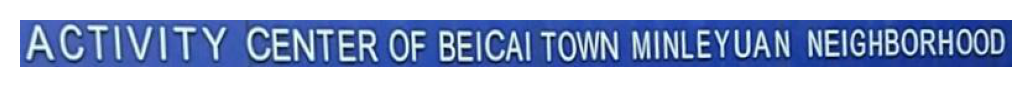

In [23]:
img = plt.imread(labeled_data_path / '273848.jpg')
plt.imshow(img), plt.grid(False), plt.axis('off');

In [66]:
torch.cuda.empty_cache()

In [67]:
# Build model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

#crnn = CRNN(alphabet=alphabet, rnn_bidirectional=True)
crnn = CRNN(alphabet=alphabet, cnn_input_size=(64, 320), cnn_output_len=50,
            rnn_hidden_size=128, rnn_num_layers=2, rnn_dropout=0.3, rnn_bidirectional=True)
crnn.to(device)

num_epochs = 10
batch_size = 128
num_workers = 2

# optimizer = optim.Adam(
#     crnn.parameters(), lr=1e-4, amsgrad=True, weight_decay=1e-5
# )
optimizer = optim.AdamW(crnn.parameters(), lr=1e-4, amsgrad=True, weight_decay=1e-2)

# criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=1/np.sqrt(10), patience=2,
    verbose=True, threshold=1e-3
)

transformations_train = transforms.Compose([
    Cv2Rezize(),
    transforms.ToPILImage(),
    transforms.RandomGrayscale(p=0.3),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
    transforms.RandomApply(transforms=[transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.2, 2))], p=0.3),
    transforms.RandomRotation(degrees=(-5, 5)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transformations = transforms.Compose([
    Cv2Rezize(),
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_ocr_dataset = RecognitionDataset(
    files_dir=labeled_data_path, data_df=labeled_data_df, 
    alphabet=alphabet, transforms=transformations_train, 
    split='train', train_size=0.9
)

val_ocr_dataset = RecognitionDataset(
    files_dir=labeled_data_path, data_df=labeled_data_df,
    alphabet=alphabet, transforms=transformations, 
    split='val'
)

train_dataloader = DataLoader(
    train_ocr_dataset, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=True,
    drop_last=True, collate_fn=collate_fn_recognition
)

val_dataloader = DataLoader(
    val_ocr_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True,
    drop_last=False, collate_fn=collate_fn_recognition
)

cuda


In [23]:
!nvidia-smi

Mon May 29 16:51:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W /  70W |    903MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [52]:
next(iter(val_dataloader))['image'].shape

torch.Size([128, 3, 64, 320])

In [53]:
with torch.no_grad():
    out = crnn(next(iter(val_dataloader))['image'].to(device)) #.cpu()
out.shape

torch.Size([50, 128, 252])

In [21]:
def pred_to_string(pred, alphabet):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])  # greedy decode
        seq.append(label - 1)  # 0: blank -> -1
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:  # skip blank
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([alphabet[c] for c in out])
    return out


def decode(preds, alphabet):
    preds = preds.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(preds)):
        outputs.append(pred_to_string(preds[i], alphabet))
    return outputs

In [30]:
!pip install levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 61.0 MB/s eta 0:00:00


In [22]:
from Levenshtein import distance

In [49]:
b = next(iter(train_dataloader))
with torch.no_grad():
    seqs_pred = crnn(b['image'].to(device)).cpu()
print(seqs_pred.shape)

log_probs = F.log_softmax(seqs_pred, dim=2)
seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

texts_pred = decode(seqs_pred, crnn.alphabet)
texts_gt = b['text']

seqs_gt = b['seq']
seq_lens_gt = b['seq_len']
loss = F.ctc_loss(log_probs=log_probs,  # (T, N, C)
                  targets=seqs_gt,  # N, S or sum(target_lengths)
                  input_lengths=seq_lens_pred,  # N
                  target_lengths=seq_lens_gt)  # N

loss.item()

torch.Size([50, 128, 252])


54.11152648925781

In [24]:
with torch.no_grad():
    f_ext = FeatureExtractor(input_size=(64, 320), output_len=10)
f_ext(next(iter(train_dataloader))['image']).shape

torch.Size([128, 1, 512, 10])

In [68]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def model_train_val_epoch(model, data_loader, mode='train', best_loss=np.inf):
    epoch_losses, levenshteint_losses = [], []

    if mode == 'train':
        model.train()
    elif mode == 'val':
        model.eval()
    
    for b in tqdm(data_loader, total=len(data_loader), desc=mode):
        images = b['image'].to(device)
        seqs_gt = b['seq']
        seq_lens_gt = b['seq_len']
        
        if mode == 'train':
            #optimizer.zero_grad()
            seqs_pred = model(images).cpu()
        elif mode == 'val':
            with torch.no_grad():
                seqs_pred = model(images).cpu()
        
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()
        # input_lengths = torch.IntTensor(batch_size).fill_(model.postconv_width)
        
        texts_pred = decode(seqs_pred, model.alphabet)
        texts_gt = b['text']
        levenshteint_losses.extend([distance(pred, gt) for pred, gt in zip(texts_pred, texts_gt)])

        loss = F.ctc_loss(log_probs=log_probs,  # (T, N, C)
                          targets=seqs_gt,  # N, S or sum(target_lengths)
                          input_lengths=seq_lens_pred,  # N
                          target_lengths=seq_lens_gt,  # N
                          blank=0, reduction='mean', zero_infinity=True)
        # Whether to zero infinite losses and the associated gradients. 
        # Default: False Infinite losses mainly occur when the inputs are too short to be aligned to the targets.

        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        elif mode == 'val' and best_loss > loss.item():
            best_loss = loss.item()
            with open(f'{experiment_name}.pth', 'wb') as fp:
                torch.save(model.state_dict(), fp)

        epoch_losses.append(loss.item())
    
    return epoch_losses, levenshteint_losses, best_loss

In [69]:
print(count_parameters(crnn))
# # transfer
# for p in crnn.features_extractor.cnn[:6].parameters():
#     p.requires_grad = False

12031330

In [ ]:
experiment_name = 'crnn'

best_loss = np.inf
prev_lr = optimizer.param_groups[0]['lr']
train_history, val_history = [], []

for i in range(num_epochs):
    # Load best model if LR has been changed
    if optimizer.param_groups[0]['lr'] < prev_lr:
        prev_lr = optimizer.param_groups[0]['lr']
        with open(f'{experiment_name}.pth', 'rb') as fp:
            state_dict = torch.load(fp, map_location='cpu')
        crnn.load_state_dict(state_dict)
        crnn.to(device)
    
    # TRAINING
    epoch_losses, levenshtein_losses, _ = model_train_val_epoch(crnn, train_dataloader, mode='train')
    
    print(f'epoch {i + 1}, ctc: {np.mean(epoch_losses):.3f}, levenshtein: {np.mean(levenshtein_losses):.3f}')
    train_history.append((np.mean(epoch_losses), np.mean(levenshtein_losses)))
    time.sleep(0.5)
    
    # VALIDATION
    epoch_losses, levenshtein_losses, best_loss = model_train_val_epoch(crnn, val_dataloader, mode='val', best_loss=best_loss)
    
    # if best_loss > np.mean(epoch_losses):
    #     best_loss = np.mean(epoch_losses)
    #     with open(f'{experiment_name}.pth', 'wb') as fp:
    #         torch.save(crnn.state_dict(), fp)
        
    lr_scheduler.step(np.mean(levenshtein_losses))

    print(f'epoch {i + 1}, ctc: {np.mean(epoch_losses):.3f}, levenshtein: {np.mean(levenshtein_losses):.3f}')
    print(f'best val loss: {best_loss:.3f}\n')
    val_history.append((np.mean(epoch_losses), np.mean(levenshtein_losses)))
    time.sleep(0.5)

In [ ]:
b = next(iter(train_dataloader))
with torch.no_grad():
    seqs_pred = crnn(b['image'].to(device)).cpu()
texts_pred = decode(seqs_pred, crnn.alphabet)
print(*(zip(texts_pred, b['text'], b['file_name'])), sep='\n')

# Submission

In [72]:
test_ocr_dataset = RecognitionDataset(
    files_dir=test_data_path, data_df=test_df,
    alphabet=alphabet, transforms=transformations, 
    split='test'
)

batch_size = 128
num_workers = 2

test_dataloader = DataLoader(
    test_ocr_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True,
    drop_last=False, collate_fn=collate_fn_recognition
)

In [73]:
experiment_name = 'crnn'

with open(f'{experiment_name}.pth', 'rb') as fp:
    state_dict = torch.load(fp, map_location='cpu')
crnn.load_state_dict(state_dict)
crnn.to(device)
crnn.eval()

test_preds = []
for b in tqdm(test_dataloader, total=len(test_dataloader), desc='test'):
    images = b['image'].to(device)
    with torch.no_grad():
        seqs_pred = crnn(images).cpu()
    texts_pred = decode(seqs_pred, crnn.alphabet)
    test_preds.extend(texts_pred)
    #break

test: 100%|██████████| 415/415 [01:33<00:00,  4.45it/s]


In [ ]:
decode(seqs_pred, crnn.alphabet)

In [ ]:
test_preds

In [76]:
pd.read_csv('sample_submission.csv').head()

Id   Predicted
0  1.jpg      vrxqqj
1  2.jpg    hcwqjoop
2  3.jpg      twpsjl
3  4.jpg   qudzdtxdd
4  5.jpg  oipipqztjj

In [77]:
test_df.head(10)

img       img_size  img_ratio  img_mode
0  21529.jpg    (20, 61, 3)   3.050000         3
1  15969.jpg  (113, 667, 3)   5.902655         3
2  47101.jpg  (252, 657, 3)   2.607143         3
3  25778.jpg    (12, 52, 3)   4.333333         3
4  43250.jpg   (45, 134, 3)   2.977778         3
5  27335.jpg   (24, 120, 3)   5.000000         3
6  28488.jpg   (58, 172, 3)   2.965517         3
7   9503.jpg  (121, 168, 3)   1.388430         3
8  42016.jpg   (27, 103, 3)   3.814815         3
9  16962.jpg   (138, 65, 3)   0.471014         3

In [ ]:
test_preds[:10]

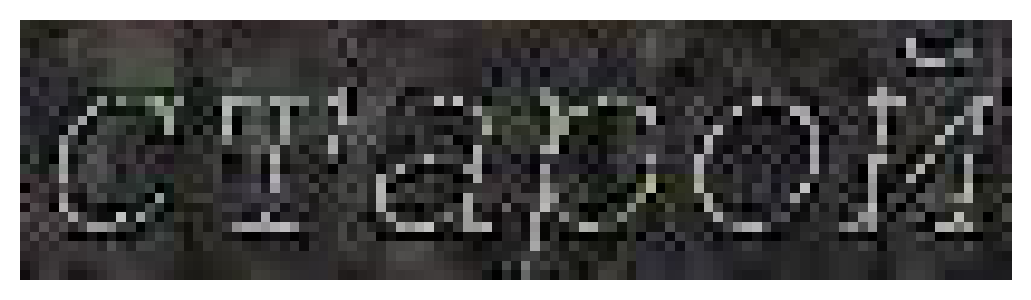

In [125]:
img = plt.imread(test_data_path / '42016.jpg')
plt.imshow(img), plt.grid(False), plt.axis('off');

In [107]:
submission_df = pd.DataFrame({'Id': test_df.img, 'Predicted': test_preds})
submission_df.to_csv('submission.csv', header=True, index=False)